# Credit Card Fraud Detection with Synthetic Financial Datasets 

    Data collected from https://www.kaggle.com/ealaxi/paysim1/code
    

###  What does the columns mean
 - step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

 #### type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
 

 - amount - amount of the transaction in local currency.

 - nameOrig - customer who started the transaction

 - oldbalanceOrg - initial balance before the transaction

 - newbalanceOrig - new balance after the transaction

 - nameDest - customer who is the recipient of the transaction

 - oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

 - newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

 - isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

 - isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
from pathlib import Path
import numpy as np
import requests
from IPython.display import display


### 1: Load The Credit Card Data and General Info


In [100]:
df = pd.read_csv('C:\\Projects\\SpringBoard\\Capstone 2\\Credit card\\Synthetic credit card.csv')

In [101]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [102]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [103]:
df.shape

(6362620, 11)

### Data Wrangling

  - Find missing values
  - Find catogorical features
  - Figure out Duplicate values if any
  - Replace NaN numbers
  - Group the data if required

 #### 2: Number Of Missing Values By Column

In [104]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [105]:
missing = pd.concat([df.isna().sum(axis=1), 100 * df.isna().mean(axis=1)], axis=1)
missing.columns=["count", '%']
missing.sort_values(by="count", ascending=False)

,count,%
0,0,0.0
4241732,0,0.0
4241754,0,0.0
4241753,0,0.0
4241752,0,0.0
...,...,...
2120869,0,0.0
2120868,0,0.0
2120867,0,0.0
2120866,0,0.0


 Observations:
  - This dataset is clean, no missing values.

#### 3: Categorical Features

In [106]:
df.select_dtypes('object')


,type,nameOrig,nameDest
0,PAYMENT,C1231006815,M1979787155
1,PAYMENT,C1666544295,M2044282225
2,TRANSFER,C1305486145,C553264065
3,CASH_OUT,C840083671,C38997010
4,PAYMENT,C2048537720,M1230701703
...,...,...,...
6362615,CASH_OUT,C786484425,C776919290
6362616,TRANSFER,C1529008245,C1881841831
6362617,CASH_OUT,C1162922333,C1365125890
6362618,TRANSFER,C1685995037,C2080388513


Observation
 - In the credit Card data set there are three object type features, nameOrig, nameDest, and type.

 ####  4.1 Check for duplicated values

In [107]:
df.duplicated(subset=None, keep='first')

0          False
1          False
2          False
3          False
4          False
           ...  
6362615    False
6362616    False
6362617    False
6362618    False
6362619    False
Length: 6362620, dtype: bool

In [108]:
df.duplicated().sum()

0

Observation
 - There are no duplicate transactions.

#### Summary of Data Wrangling

 - This Credit card data does not have any missing values, duplicates, and not a number(NaN values).
 - There are three features with object type - nameOrig, nameDest, and type.
 - oldbalanceDest and newbalanceDest information is not available for Merchants.

### Exploratory Data Analysis and Visualization

   - Summarize data
   - Find the entire list of fraud transaction
   - summary statistics of the fraud transaction
   - Figure out the Highest amount transacted and the highest amount transacted in feature "type"
   - Explain the correlation and draw the heatmap
   - How each feature catogory is related to the fraud transaction
   - Find the relationship between "isFraud" and "isFlaggedFraud" columns with the other important features
   - Explain How the fraud and non fraud transaction reltionship with the oldbalanceOrg, oldbalanceDest, newbalanceDest
   - Figure out the peak fraud transaction hours.

In [109]:
#statistically summarizing the data.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'oldbalanceOrg'}>],
       [<AxesSubplot:title={'center':'newbalanceOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>,
        <AxesSubplot:title={'center':'newbalanceDest'}>],
       [<AxesSubplot:title={'center':'isFraud'}>,
        <AxesSubplot:title={'center':'isFlaggedFraud'}>, <AxesSubplot:>]],
      dtype=object)

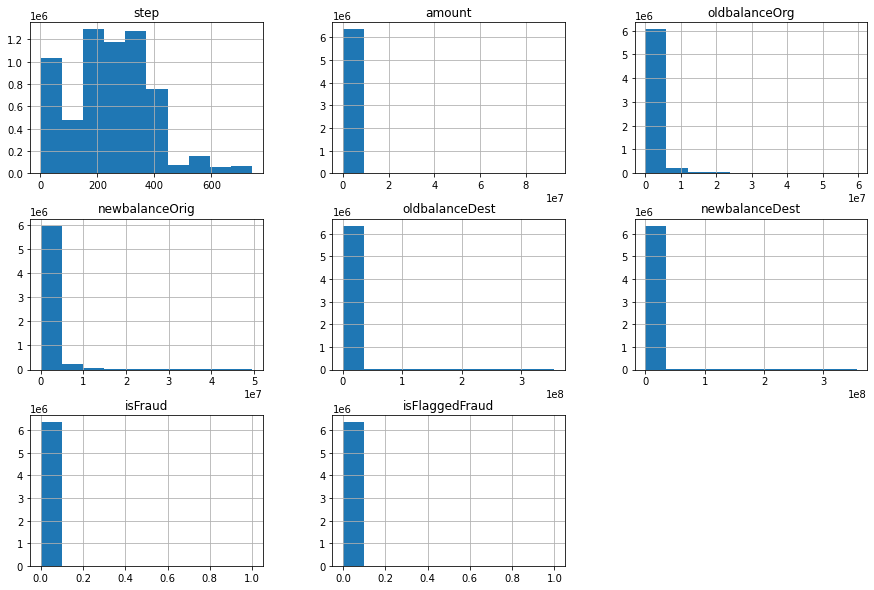

In [110]:
#show the histogram
df.hist(figsize=(15,10))

In [111]:
#find fraud count
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [112]:
# Find the entire list of fraud transaction and assign the value to 'is_fraud'
is_fraud = df[df["isFraud"] > 0]
is_fraud.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0


In [113]:
#summarize the values of 'is_fraud'
is_fraud.describe().T

,count,mean,std,min,25%,50%,75%,max
step,8213.0,3.684139e+02,2.163887e+02,1.0,181.00,367.00,558.00,7.430000e+02
amount,8213.0,1.467967e+06,2.404253e+06,0.0,127091.33,441423.44,1517771.48,1.000000e+07
oldbalanceOrg,8213.0,1.649668e+06,3.547719e+06,0.0,125822.44,438983.45,1517771.48,5.958504e+07
newbalanceOrig,8213.0,1.923926e+05,1.965666e+06,0.0,0.00,0.00,0.00,4.958504e+07
oldbalanceDest,8213.0,5.442496e+05,3.336421e+06,0.0,0.00,0.00,147828.66,2.362305e+08
newbalanceDest,8213.0,1.279708e+06,3.908817e+06,0.0,0.00,4676.42,1058725.22,2.367265e+08
isFraud,8213.0,1.000000e+00,0.000000e+00,1.0,1.00,1.00,1.00,1.000000e+00
isFlaggedFraud,8213.0,1.948131e-03,4.409731e-02,0.0,0.00,0.00,0.00,1.000000e+00


In [114]:
print("Highest amount transacted:", df['amount'].max()); print()

# highest transaction amount for each transaction type
print("Highest amount transacted in each transaction type:")

for catogory in df['type'].unique():
    print(f"\t Highest amount transacted in {catogory} type is {df.loc[(df['type'] == catogory), 'amount'].max()}")

Highest amount transacted: 92445516.64

Highest amount transacted in each transaction type:
	 Highest amount transacted in PAYMENT type is 238637.98
	 Highest amount transacted in TRANSFER type is 92445516.64
	 Highest amount transacted in CASH_OUT type is 10000000.0
	 Highest amount transacted in DEBIT type is 569077.51
	 Highest amount transacted in CASH_IN type is 1915267.9


  - Highest amount transacted in TRANSFER type is 92445516.64
  - Highest amount transacted in CASH_OUT type is 10000000.0

In [115]:
#Figure out the maximum and the minumum amount of Fraud transaction
print("Min fraud transaction amount:", is_fraud['amount'].min())
print("Max fraud transaction amount:", is_fraud['amount'].max())

Min fraud transaction amount: 0.0
Max fraud transaction amount: 10000000.0


In [116]:
#Find the mean value of each catogory in type column
df.groupby('type')['isFraud'].mean()

type
CASH_IN     0.000000
CASH_OUT    0.001840
DEBIT       0.000000
PAYMENT     0.000000
TRANSFER    0.007688
Name: isFraud, dtype: float64

In [117]:
list(df.loc[(df.isFraud==1)].type.unique())

['TRANSFER', 'CASH_OUT']

In [118]:
df[(df.amount == 0) & (df.isFraud == 1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 2736447 to 6362585
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            16 non-null     int64  
 1   type            16 non-null     object 
 2   amount          16 non-null     float64
 3   nameOrig        16 non-null     object 
 4   oldbalanceOrg   16 non-null     float64
 5   newbalanceOrig  16 non-null     float64
 6   nameDest        16 non-null     object 
 7   oldbalanceDest  16 non-null     float64
 8   newbalanceDest  16 non-null     float64
 9   isFraud         16 non-null     int64  
 10  isFlaggedFraud  16 non-null     int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.5+ KB


Here the amount of 16 transactions are zero which is 'is_fraud'

In [119]:
df[(df.amount == 0) & (df.isFraud == 1)].head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0


###  Visualisation

In [120]:
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


<AxesSubplot:>

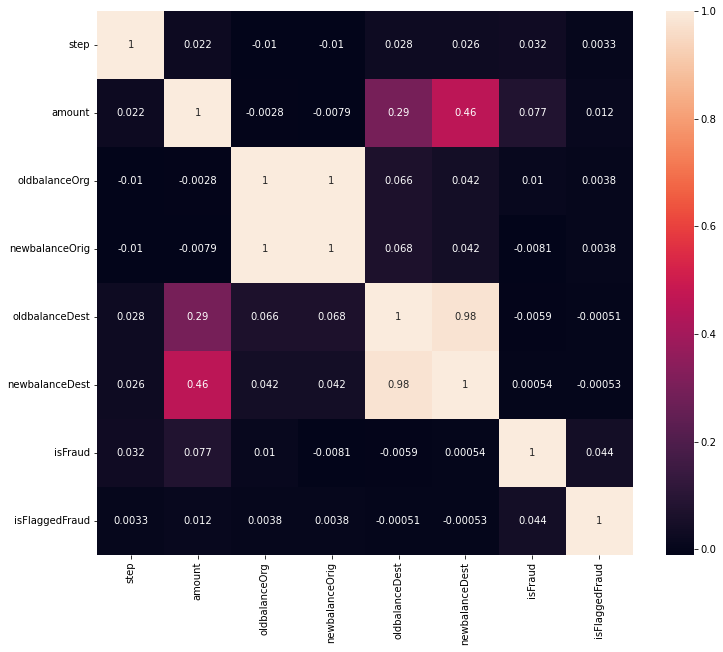

In [121]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)


<AxesSubplot:>

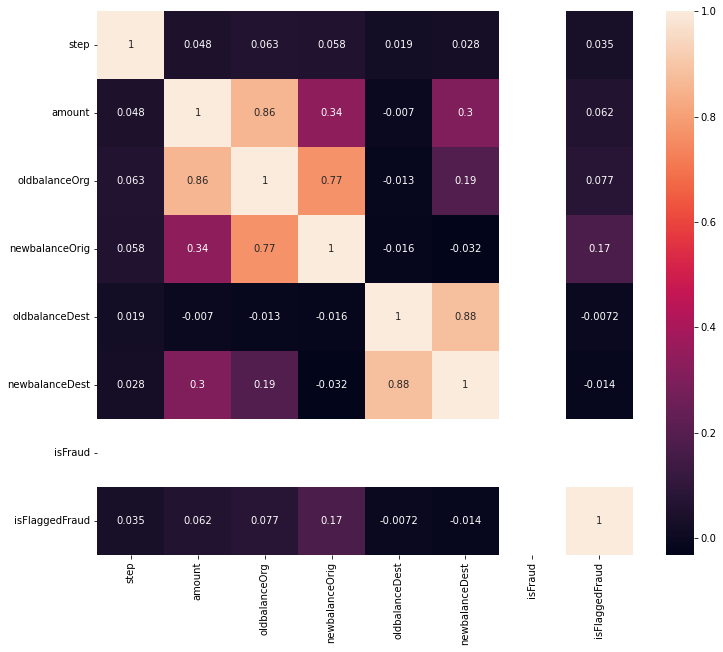

In [122]:
#Draw the heat map of is_fraud
plt.figure(figsize=(12,10))
sns.heatmap(is_fraud.corr(), annot=True)

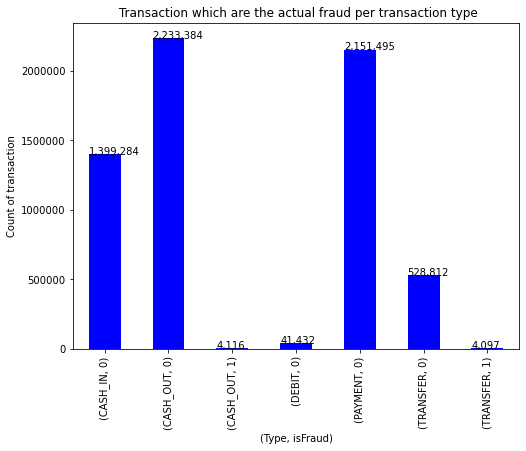

In [123]:
#Draw a bar diagram to show the relationship between the fraud transaction "isFraud" and "type".

ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar',figsize=(8, 6), color='blue')
ax.set_title(" Transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
plt.ticklabel_format(style='plain', axis='y')
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

Here the CASH_OUT and PAYMENT are gives the highest value in 'isFraud' and 'isFlaggedFraud' columns.
There are 4116 fraud transactions in CASH_OUT and 4097 transactions in TRANSFER.

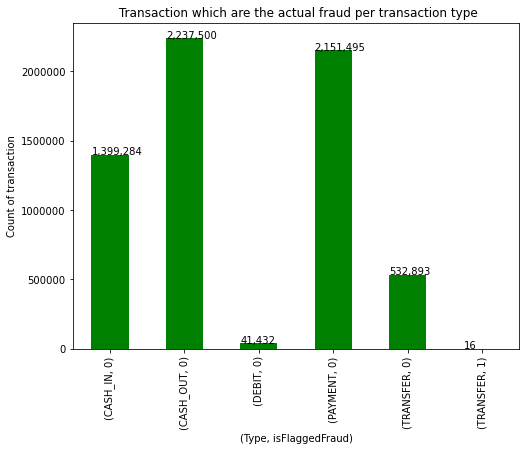

In [124]:
#Draw a bar diagram to show the relationship between the fraud transaction and type.
ax = df.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar',figsize=(8, 6), color='green')
ax.set_title(" Transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
plt.ticklabel_format(style='plain', axis='y')
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

Observations
 - From the above bar chart, most of the fraud transaction done in PAYMENT and CASH_OUT catogory. Also, we can see there are 16 system flagged fraud transactions in TRANSFER.

C:\Users\archu\AppData\Local\Temp/ipykernel_5912/1689052668.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


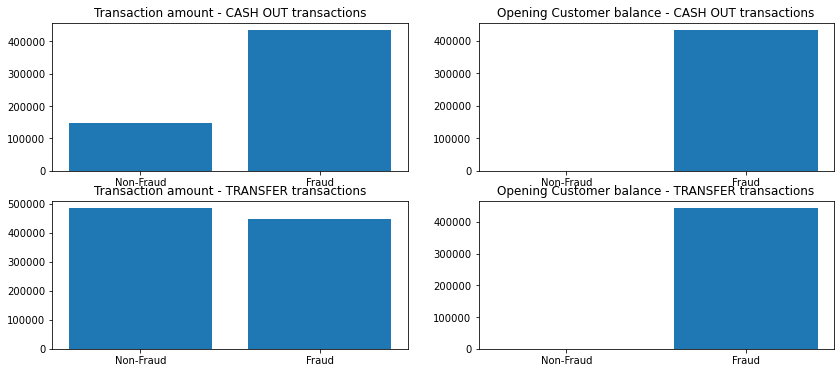

In [125]:
fig,ax=plt.subplots(2,2,figsize=(14,6))
ax[0][0].title.set_text("Transaction amount - CASH OUT transactions")
ax[0][0].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="CASH_OUT"].groupby("isFraud")["amount"].median())

ax[0][1].title.set_text("Opening Customer balance - CASH OUT transactions")
ax[0][1].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="CASH_OUT"].groupby("isFraud")["oldbalanceOrg"].median())


ax[1][0].title.set_text("Transaction amount - TRANSFER transactions")
ax[1][0].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="TRANSFER"].groupby("isFraud")["amount"].median())

ax[1][1].title.set_text("Opening Customer balance - TRANSFER transactions")
ax[1][1].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="TRANSFER"].groupby("isFraud")["oldbalanceOrg"].median())
fig.show()

C:\Users\archu\AppData\Local\Temp/ipykernel_5912/1057753936.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


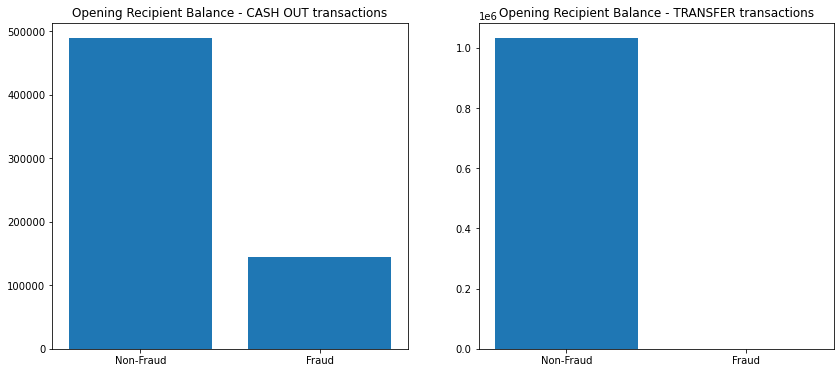

In [126]:
fig,ax=plt.subplots(1,2,figsize=(14,6))
ax[0].title.set_text("Opening Recipient Balance - CASH OUT transactions")
ax[0].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="CASH_OUT"].groupby("isFraud")["oldbalanceDest"].median())

ax[1].title.set_text("Opening Recipient Balance - TRANSFER transactions")
ax[1].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="TRANSFER"].groupby("isFraud")["oldbalanceDest"].median())
fig.show()

In [127]:
is_fraud = df[df["isFraud"] > 0]
not_fraud = df[df["isFraud"] == 0]

In [128]:
print("Fraud:",  is_fraud.shape)
print("Not Fraud:",  not_fraud.shape)

Fraud: (8213, 11)
Not Fraud: (6354407, 11)


In [129]:
len(df.loc[(df.isFraud==1)&(df.type=='TRANSFER')])

4097

In [130]:
len(df.loc[(df.isFraud==1)&(df.type=='CASH_OUT')])

4116


We can look at the recipient's opening balance for fraud and non-fraud cash-out and transfer transactions seperately. From the plots, we see the variable is very less for transfer fraud transactions compared to transfer non-fraud transactions which is reverse of what we observed in customer balance.

In [131]:
is_fraud.groupby('nameDest').size().value_counts().reset_index().rename(columns={'index':'No. of Fraudulent Transactions per Destination Account',
                                                                                 0:'No. of Unique Accounts'})

,No. of Fraudulent Transactions per Destination Account,No. of Unique Accounts
0,1,8125
1,2,44


Observation:

Here we see there are 2 times the fraud transactions done in 44 accounts.

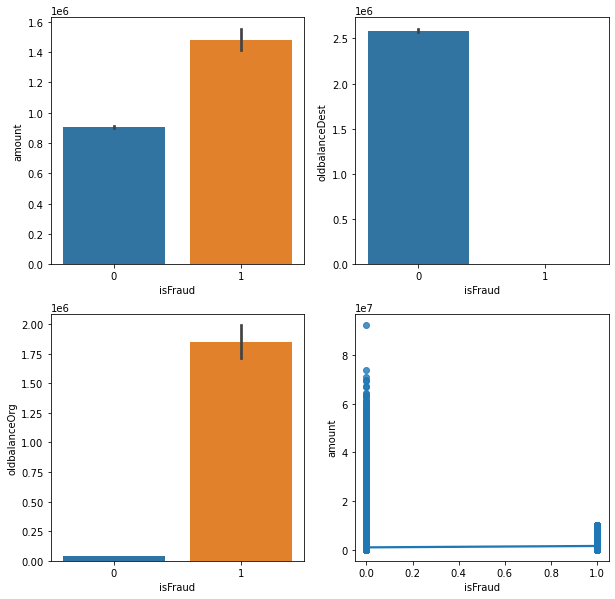

In [132]:
#Explain How the fraud and non fraud transaction relationship with the oldbalanceOrg, oldbalanceDest, newbalanceDest

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
data = df.loc[(df.type == 'TRANSFER'), :]

sns.barplot(x = 'isFraud', y = 'amount', data = data, ax=axs[0][0])


sns.barplot(x = 'isFraud', y = 'oldbalanceDest', data = data, ax=axs[0][1])


sns.barplot(x = 'isFraud', y = 'oldbalanceOrg', data=data, ax=axs[1][0])


sns.regplot(x='isFraud', y='amount', data=data)
plt.show()

In [147]:
df['transactionHour'] = df['step'] % 24

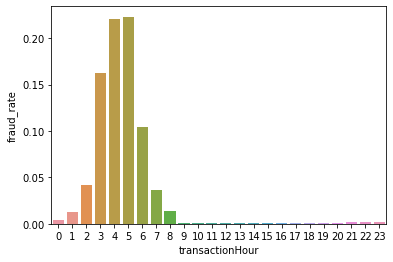

In [148]:
frauds_hour = pd.concat([df.groupby("transactionHour")["isFraud"].sum(),df.groupby("transactionHour")["isFraud"].count()],axis=1)

frauds_hour.columns = ["Frauds","Transactions"]
frauds_hour["fraud_rate"] = frauds_hour.Frauds/frauds_hour.Transactions
sns.barplot(x=frauds_hour.index,y=frauds_hour.fraud_rate)
plt.show()

Observations:

Most of the fraud transactions are happening after 12:00am to 8:00am. The data is stable during the banking hours.

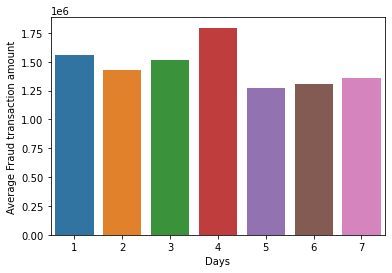

In [149]:
df["one_week"] = df.transactionHour % 7
sns.barplot(x=list(range(1,8)),y=df[df.isFraud==1].groupby("one_week")["amount"].mean())
plt.xlabel("Days")
plt.ylabel("Average Fraud transaction amount")
plt.show()

Fraudulent transaction is almost consistent across days

Text(0.5, 1.0, 'No. of obervations at each hour')

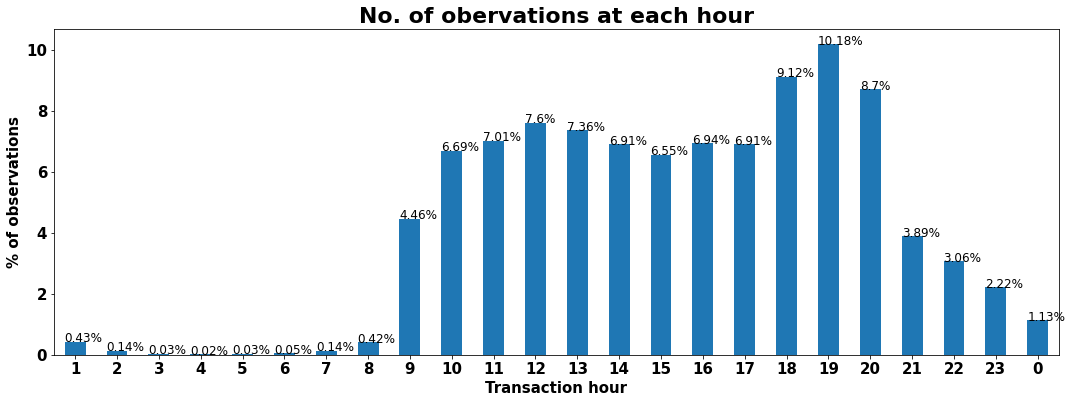

In [150]:
# number of transactions in each hour
plt.figure(figsize=(18,6))
ax = (df['transactionHour'].value_counts(sort=False, normalize=True) * 100).round(2).plot(kind='bar')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)) + "%", fontsize=12, color='black')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% of observations', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. of obervations at each hour', fontsize=22, fontweight='bold')


Observations:
    
Here the most transactions are happening during the day time 9:00am to 8:00pm. Then it is deducing. 

######  Transaction between¶

 - Define whether the transfer happened from Customer to Merchant or from Customer to Customer.

In [151]:
df['transactionBetween'] = df['nameDest'].apply(lambda x: 'Customer_Customer' if x[0] == "C" else 'Customer_Merchant')

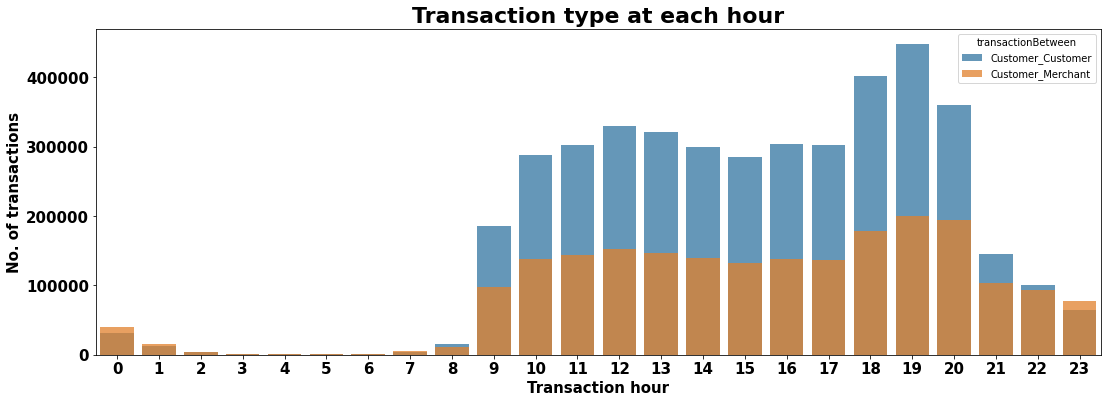

In [152]:
# avg. transaction amount at each hour for each transaction type
plt.figure(figsize=(18,6))
sns.barplot(data=df.groupby(['transactionHour','transactionBetween']).size().reset_index(),
            x='transactionHour',
            y=0,
            hue='transactionBetween',
            dodge=False,
            alpha=0.75)
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('No. of transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Transaction type at each hour', fontsize=22, fontweight='bold')
plt.show()

observations:

In Normal hours, Customer to Customer transactions are greater than Customer to Merchant transactions.
But Customer to Merchant transactions are happening off-peak hours 


#### Summary of Exploratory Data Analysis:
    
   - When we explore the data it clearly says there are 8213 fraud transactions reported.
   
   
   - From the plots, we see the variable is very less for transfer fraud transactions compared to transfer non-fraud transactions which is reverse of what we observed in customer balance.
   
   
   
   - The highest amount transacted is 
     - the maximum amount of Fraud transaction is 
     - The The main fraud transaction catogories are TRANSFER and CASH_OUT.
     
     
     
   - There are 4116 Fraud transaction in CASH_OUT and 4097 in TRANSFER
   
   - There are 16 system flagged fraud transaction in feature isFlaggedFraud. Also, the bar diagram projecting the PAYMENT and CASH_out features
   
   
   - Most of the fraud transactions are happening after 12:00am to 8:00am. The data is stable during the banking hours. 
   
   

In [ ]:
# Save the data 
from library.sb_utils import save_file

datapath = '.'

save_file(df, 'creditcard_preprocessing.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  ".\creditcard_preprocessing.csv"
